# Config

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score, mean_squared_error
from tqdm import tqdm

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..')) if 'notebooks' in current_dir else current_dir

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir(project_root)
    print(f"Cambio directory di lavoro: {os.getcwd()}")
else:
    print(f"Directory di lavoro attuale: {os.getcwd()}")

if project_root not in sys.path:
    sys.path.append(project_root)

from src.config import *
from src.dataset import *
from src.model import FaceModel

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cambio directory di lavoro: c:\Users\antonio\OneDrive\Desktop\Progetti\Age&Emotion Recognition


## Utilities

In [3]:
# Fix per pathlib su OS diversi (Windows/Linux mix)
import pathlib
sys.modules['pathlib._local'] = pathlib


def load_trained_model(checkpoint_path, model_name, task, num_classes=7):
    print(f"Costruzione modello {model_name}...")
    
    mode = 'classification' if task == 'emotion' else 'regression'
    model = FaceModel(model_name=model_name, mode=mode, num_classes=num_classes, pretrained=True)
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint non trovato: {checkpoint_path}")
    
    print(f"Caricamento pesi da: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Gestione compatibilità nomi (DataParallel)
    state_dict = checkpoint['model_state_dict']
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
        
    model.load_state_dict(new_state_dict)
    model.to(device)
    model.eval() 
    return model

def get_predictions(model, loader, task):
    """
    Esegue l'inferenza su tutto il dataloader e restituisce Ground Truth e Predizioni.
    """
    y_true = []
    y_pred = []

    print(f"Avvio inferenza ({task})...")
    with torch.no_grad():
        for batch in tqdm(loader):
            if len(batch) == 3: # Age dataset ha 3 output (img, label, weight)
                images, targets, _ = batch
            else: # Emotion dataset ha 2 output
                images, targets = batch

            images = images.to(device)
            outputs = model(images)

            if task == 'emotion':
                # Per classificazione prendiamo l'indice con probabilità massima
                _, preds = torch.max(outputs, 1)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(targets.numpy())
            else:
                # Per regressione prendiamo il valore float
                preds = outputs.squeeze().cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(targets.numpy())

    return np.array(y_true), np.array(y_pred)

## Emotion Model

Caricamento split Emozioni esistenti...
Dataloaders pronti per EMOTION
   Train: 28709 sample | Val: 7178 sample
Classi caricate: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Costruzione modello convnext_tiny...
Loading convnext_tiny (Pretrained=True)...


C:\Users\antonio\AppData\Local\Temp\ipykernel_18468\3298257320.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  meta = torch.load(meta_path, map_location='cpu')


Caricamento pesi da: checkpoints/emotion_best/best_model.pth


C:\Users\antonio\AppData\Local\Temp\ipykernel_18468\1480648121.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=dev

Avvio inferenza (emotion)...


100%|██████████| 57/57 [01:05<00:00,  1.15s/it]



CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry     0.6704    0.6690    0.6697       991
     disgust     0.8961    0.6330    0.7419       109
        fear     0.6816    0.5645    0.6175      1024
       happy     0.8685    0.8966    0.8823      1798
     neutral     0.6411    0.7492    0.6910      1240
         sad     0.6252    0.5831    0.6034      1216
    surprise     0.8206    0.8462    0.8332       800

    accuracy                         0.7296      7178
   macro avg     0.7434    0.7059    0.7199      7178
weighted avg     0.7291    0.7296    0.7273      7178



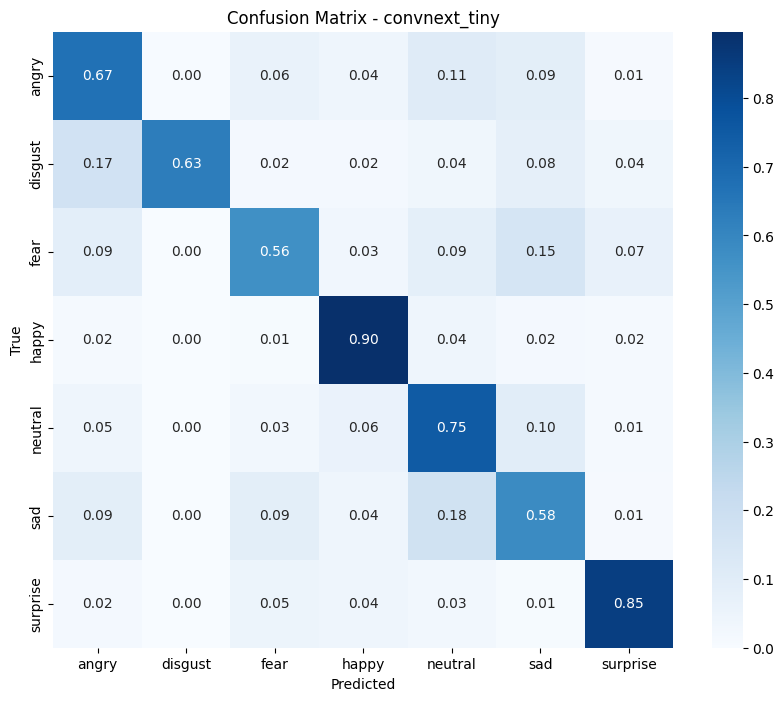

In [4]:
import src.config
import src.dataset

# Resize e crop size per convnext_tiny
RESIZE_SIZE = 236
CROP_SIZE = 224

src.dataset.data_transforms['val'] = transforms.Compose([
    transforms.Resize(RESIZE_SIZE),        
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
src.config.RESIZE_SIZE = RESIZE_SIZE
src.config.CROP_SIZE = CROP_SIZE

EMO_CHECKPOINT = "checkpoints/emotion_best/best_model.pth"
EMO_MODEL_NAME = "convnext_tiny"

_, val_loader, _ = get_dataloaders('emotion', batch_size=128)

meta_path = 'metadata_splits/emotion_meta.pt'

meta = torch.load(meta_path, map_location='cpu')
class_to_idx = meta['class_map']
idx_to_class = {v: k for k, v in class_to_idx.items()}
correct_target_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print(f"Classi caricate: {correct_target_names}")

model_emo = load_trained_model(EMO_CHECKPOINT, EMO_MODEL_NAME, task='emotion')
y_true, y_pred = get_predictions(model_emo, val_loader, task='emotion')

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=correct_target_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=correct_target_names, 
            yticklabels=correct_target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {EMO_MODEL_NAME}')
plt.show()

## Age Model

Caricamento split Età esistenti...
Dataloaders pronti per AGE
   Train: 18966 sample | Val: 4742 sample
Costruzione modello efficientnet_v2_s...
Loading efficientnet_v2_s (Pretrained=True)...
Caricamento pesi da: checkpoints/age_best/best_model.pth


C:\Users\antonio\AppData\Local\Temp\ipykernel_18468\1480648121.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=dev

Avvio inferenza (age)...


100%|██████████| 149/149 [01:35<00:00,  1.56it/s]



STATISTICHE REGRESSIONE (efficientnet_v2_s):
   MAE (Mean Absolute Error): 4.9597 anni
   RMSE (Root Mean Sq Error): 7.3474 anni
   R2 Score: 0.8632


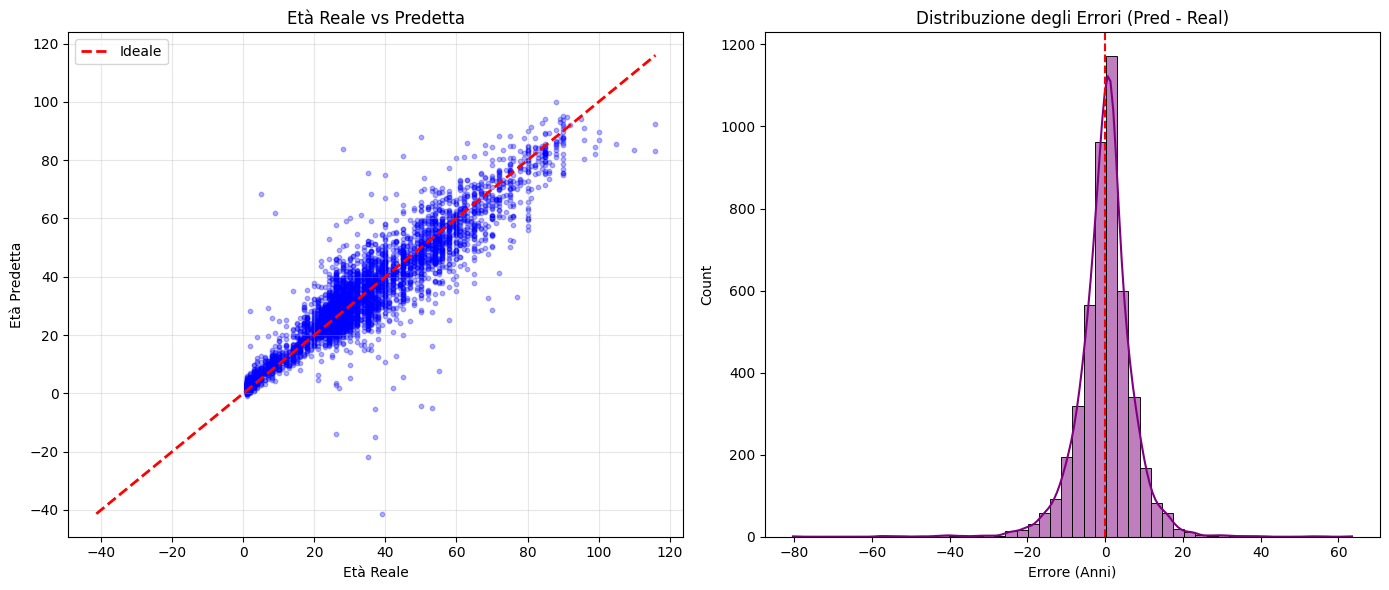

In [5]:
import src.config
import src.dataset

# Resize e crop size per efficientnet_v2_s
RESIZE_SIZE = 384
CROP_SIZE = 384

src.dataset.data_transforms['val'] = transforms.Compose([
    transforms.Resize(RESIZE_SIZE),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
src.config.RESIZE_SIZE = RESIZE_SIZE
src.config.CROP_SIZE = CROP_SIZE

AGE_CHECKPOINT = "checkpoints/age_best/best_model.pth"   
AGE_MODEL_NAME = "efficientnet_v2_s"                     

_, val_age_loader, _ = get_dataloaders('age', batch_size=32)

model_age = load_trained_model(AGE_CHECKPOINT, AGE_MODEL_NAME, task='age', num_classes=1)
y_true_age, y_pred_age = get_predictions(model_age, val_age_loader, task='age')

mae = mean_absolute_error(y_true_age, y_pred_age)
mse = mean_squared_error(y_true_age, y_pred_age)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_age, y_pred_age)

print(f"\nSTATISTICHE REGRESSIONE ({AGE_MODEL_NAME}):")
print(f"   MAE (Mean Absolute Error): {mae:.4f} anni")
print(f"   RMSE (Root Mean Sq Error): {rmse:.4f} anni")
print(f"   R2 Score: {r2:.4f}")

plt.figure(figsize=(14, 6))

# Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(y_true_age, y_pred_age, alpha=0.3, color='blue', s=10)

# Linea ideale (x=y)
min_val = min(y_true_age.min(), y_pred_age.min())
max_val = max(y_true_age.max(), y_pred_age.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Ideale')

plt.title('Età Reale vs Predetta')
plt.xlabel('Età Reale')
plt.ylabel('Età Predetta')
plt.legend()
plt.grid(alpha=0.3)

# Istogramma Errore
plt.subplot(1, 2, 2)
errors = y_pred_age - y_true_age
sns.histplot(errors, kde=True, bins=50, color='purple')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribuzione degli Errori (Pred - Real)')
plt.xlabel('Errore (Anni)')

plt.tight_layout()
plt.show()